In [1]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import collections
import multibinner as mb

In [2]:
from skimage import io
image = np.flipud(io.imread('https://media4.giphy.com/media/S3mBspMr0r5HW/200_s.gif'))

# Dataset

Initial data are read from and image, then `n_data` samples will be extraxted from the data.

The image contaons `200x200 = 40k` pixels

We will extract `400k` random points from the image and build a `pandas.DataFrame`

This mimic the sampling process of a spacecraft for example : looking a target (Earth or anotehr body) and getting way more data point you need to rconstruct a cohrent representation.

Moreover, visualize `400k x 3` columns of point is difficult, thus we will multibin the DataFrame to `200` bins on the `x` and `200` on the `y` direction, calculate the average for each bin and return `200x200` array of data in output.

The multibin.MultiBinnedDataFrame could generate as many dimension as one like, the 2D example here is for the sake of representation.

In [3]:
image_df = pd.DataFrame(image.reshape(-1,image.shape[-1]),columns=['red','green','blue'])
image_df.describe()

,red,green,blue
count,40000.000000,40000.000000,40000.000000
mean,47.090475,25.723300,34.231950
std,82.890291,54.544805,72.300951
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,47.000000,20.000000,20.000000
max,254.000000,254.000000,254.000000


In [4]:
n_data = image.reshape(-1,image.shape[-1]).shape[0]*10 # 10 times the original number of pixels : overkill!
x = np.random.random_sample(n_data)*image.shape[1]
y = np.random.random_sample(n_data)*image.shape[0]

In [5]:
data =  pd.DataFrame({'x' : x, 'y' : y })

# exctract the andom point from the original image and add some noise
for index,name in zip(*(range(image.shape[-1]),['red','green','blue'])):
    data[name] = image[data.y.astype(int),data.x.astype(int),index]+np.random.rand(n_data)*.1

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
x,400000,100.263406,57.754107,7.381100e-06,50.280294,100.353366,150.265268,199.999664
y,400000,99.962667,57.699804,5.099276e-04,50.069307,100.014117,149.758329,199.999850
red,400000,47.192283,82.955866,2.707846e-09,0.040020,0.079993,47.014229,254.099999
green,400000,25.748771,54.477645,2.671977e-08,0.039998,0.080019,20.095695,254.099992
blue,400000,34.213376,72.194960,4.496242e-08,0.040098,0.079982,20.056783,254.099996


## Data Visualization

[It is a downsampled version of the dataset, the full version would take around 1 minute per plot to visualize...]

Does this dataset make sense for you? can you guess the original imgage?

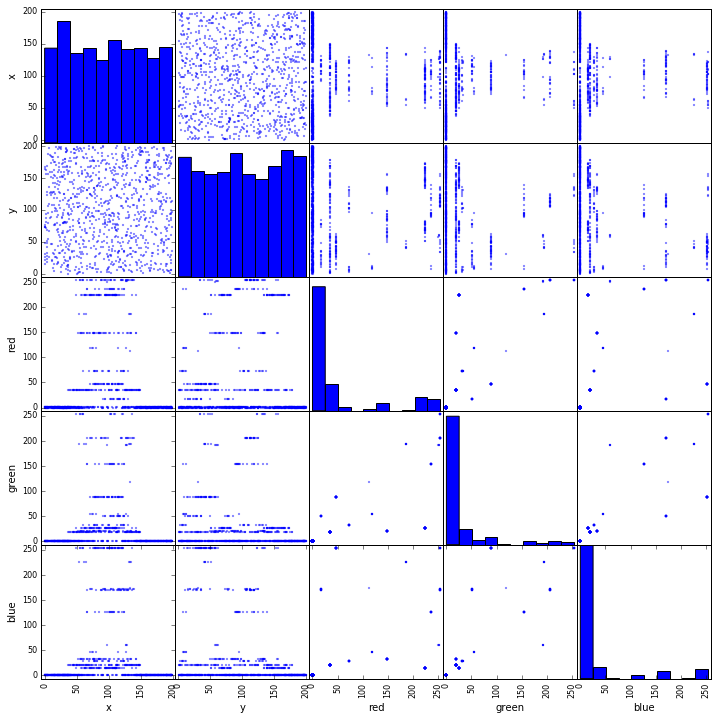

In [7]:
pd.tools.plotting.scatter_matrix(data.sample(n=1000), alpha=0.5 , lw=0, figsize=(12, 12), diagonal='hist');

In [8]:
# Let's multibinning!

# functions we want to apply on the data in a single multidimensional bin:
aggregated_functions = {
    'red'   : {'elements' : len ,'average' : np.average},
    'green' : {'average' : np.average},
    'blue'  : {'average' : np.average}
    }

# the columns we want to have in output:
out_columns = ['red','green','blue']

# define the bins for sepal_length
group_variables = collections.OrderedDict([
                    ('y',mb.bingenerator({ 'start' : 0 ,'stop' : image.shape[0], 'n_bins' : image.shape[0]})),
                    ('x',mb.bingenerator({ 'start' : 0 ,'stop' : image.shape[1], 'n_bins' : image.shape[1]}))
                    ])
# I use OrderedDict to have fixed order, a normal dict is fine too.

# that is the object colelcting all the data that define the multi binning
mbdf =  mb.MultiBinnedDataFrame(binstocolumns = True,
                                dataframe = data,
                                group_variables = group_variables,
                                aggregated_functions = aggregated_functions,
                                out_columns = out_columns)

In [9]:
mbdf.MBDataFrame.describe().T

,count,mean,std,min,25%,50%,75%,max
blue_average,40000,34.281937,72.300991,0.000087,0.047613,0.057960,20.051544,254.095256
green_average,40000,25.773277,54.544800,0.003442,0.047643,0.057995,20.065312,254.079269
red_average,40000,47.140474,82.890276,0.005333,0.047774,0.058014,47.039703,254.082816
red_elements,40000,10.000000,3.158148,1.000000,8.000000,10.000000,12.000000,25.000000
y,40000,100.000000,57.735027,0.500000,50.250000,100.000000,149.750000,199.500000
x,40000,100.000000,57.735027,0.500000,50.250000,100.000000,149.750000,199.500000


In [10]:
# reconstruct the multidimensional array defined by group_variables
outstring = []

for key,val in mbdf.group_variables.iteritems():
    outstring.append('{} bins ({})'.format(val['n_bins'],key))

key = 'red_average'

print '{} array = {}'.format(key,' x '.join(outstring))
print 
print mbdf.col_df_to_array(key)

red_average array = 200 bins (y) x 200 bins (x)

[[ 0.05127712  0.0652712   0.04811496 ...,  0.04172704  0.05627255
   0.0473071 ]
 [ 0.04585184  0.04674475  0.04773251 ...,  0.04038853  0.04045124
   0.05153442]
 [ 0.06196471  0.05289756  0.0470766  ...,  0.05191445  0.04677261
   0.04892047]
 ..., 
 [ 0.05312529  0.04845916  0.0540913  ...,  0.05445298  0.04990296
   0.05690767]
 [ 0.04087269  0.03389485  0.05597557 ...,  0.05773319  0.05013263
   0.04475328]
 [ 0.03370772  0.03759188  0.06188008 ...,  0.03841522  0.05908078
   0.05958728]]


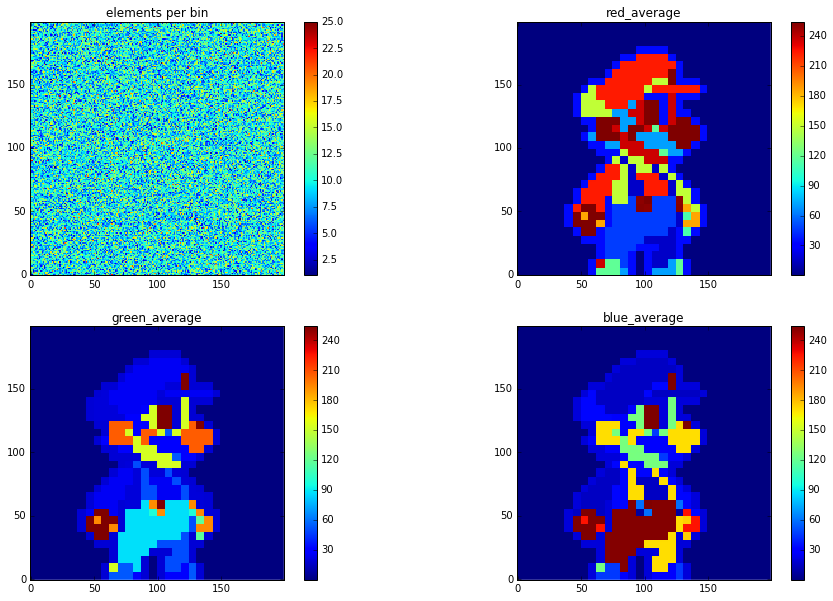

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=[16,10], ncols=2, nrows=2)

cm = plt.get_cmap('jet')

key = 'red_elements'
imgplot = ax1.imshow(mbdf.col_df_to_array(key), cmap = cm, 
                     interpolation='none',origin='lower')
plt.colorbar(imgplot, orientation='vertical', ax = ax1)
ax1.set_title('elements per bin')
ax1.grid(False) 

key = 'red_average'
imgplot = ax2.imshow(mbdf.col_df_to_array(key), cmap = cm,
                     interpolation='none',origin='lower')
plt.colorbar(imgplot, orientation='vertical', ax = ax2)
ax2.set_title(key)
ax2.grid(False) 

key = 'green_average'
imgplot = ax3.imshow(mbdf.col_df_to_array(key), cmap = cm, 
                     interpolation='none',origin='lower')
plt.colorbar(imgplot, orientation='vertical', ax = ax3)
ax3.set_title(key)
ax3.grid(False) 

key = 'blue_average'
imgplot = ax4.imshow(mbdf.col_df_to_array(key), cmap = cm, 
                     interpolation='none',origin='lower')
plt.colorbar(imgplot, orientation='vertical', ax = ax4)
ax4.set_title(key)
ax4.grid(False) 

In [12]:
rgb_image_dict = mbdf.all_df_to_array()

rgb_image = rgb_image_dict['red_average']

for name in ['green_average','blue_average']:
    rgb_image = np.dstack((rgb_image,rgb_image_dict[name]))

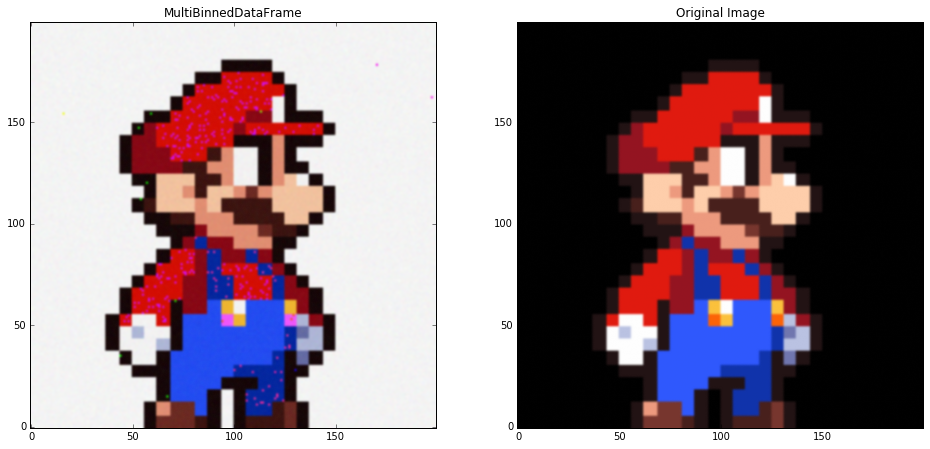

In [13]:
fig, (ax1,ax2) = plt.subplots(figsize=[16,10], ncols=2)
ax1.imshow(255-rgb_image,interpolation='bicubic',origin='lower')
ax1.set_title('MultiBinnedDataFrame')

ax2.imshow(image    ,interpolation='bicubic',origin='lower')
ax2.set_title('Original Image')

In the images above, on the right the original one and on the left the result of picking 400k random point on the image, rebinning to `200x200` on the `(x,y)` columns and calculating the average on each of the resulting `40k`bins.

The bins contain from 1 to 29 point (10 on average).

Thanks from me and Mario!